# HMM Algorithms

Hidden Markov Models are used to identify regimes, thus discretizing the time series, that can then be used to train the Bayesian Network. The HMMS has three phases, which can be solved by the following algorithms.

1. Evaluation
    - Forward Algorithm
    - Backward Algorithm
2. Decoding
    - Viterbi Algorithm
3. Training
    - Baum-Welch Algorithm

## Forward Algorithm

Forward Algorithm is used to compute the the probability of a specific observation sequence occurring at a particular state at a given time step. It  computes the probability of reaching certain state i at time t, having observed the initial sequence of observations up to that time.

Example: The forward algorithm is often used in sequence alignment, speech recognition, and natural language processing.


**Inputs:**

  - T: Number of time steps
  - States: List of possible hidden states
  - Initial_Prob: Probability distribution for initial state
  - Transition_Prob: Matrix of transition probabilities between states
  - Emission_Prob: Matrix of emission probabilities for each state-observation pair
  - Observations: List of observations for each time step

        Forward_Algo(T, States, Initial_Prob, Transition_Prob, Emission_Prob, Observations):
            # Initialize forward probabilities
            Forward = [[0 for _ in States] for _ in range(T + 1)]
    
            # Set initial probabilities
            for i in range(len(States)):
                Forward[0][i] = Initial_Prob[i] * Emission_Prob[i][Observations[0]]
    
            # Iterate through time steps
            for t in range(1, T + 1):
                for j in range(len(States)):
                # Sum over previous states
                Forward[t][j] = sum(Forward[t - 1][i] * Transition_Prob[i][j] *
                                Emission_Prob[j][Observations[t - 1]]
                                for i in range(len(States)))
    
            # Return the final forward probabilities
            return Forward[T]

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BayesianEstimator
from pgmpy.sampling import BayesianModelSampling
import hmms
import warnings
warnings.filterwarnings('ignore')

In [2]:
def forward_algorithm(O, A, B, pi):
    """
    Parameters:
    O -- observed sequence
    A -- transition matrix of the HMM
    B -- emission matrix of the HMM
    pi -- initial probability distribution

    Returns:
    P -- probability of observing the sequence
    alpha -- forward probability matrix
    """
    N = len(A)  # Number of states
    T = len(O)  # Length of the observed sequence

    # Initialize the forward probability matrix
    alpha = [[0] * T for _ in range(N)]

    # Initialization
    for i in range(N):
        alpha[i][0] = pi[i] * B[i][O[0]]

    # Recursion
    for t in range(1, T):
        for j in range(N):
            sum_term = sum(alpha[i][t-1] * A[i][j] for i in range(N))
            alpha[j][t] = B[j][O[t]] * sum_term

    # Termination
    P = sum(alpha[i][-1] for i in range(N))

    return P, alpha

## Backward Algorithm

Backward algorithm works in opposite compared to forward algorithm. It computes
probability of observing a specific sequence(remaining) given the current state. It calculates probability backwards, the remaining sequence from each state

The backward algorithm is used as conjunction with forward algorithm for parameter estimation.

**Inputs:**

  - T: Number of time steps
  - States: List of possible hidden states
  - Transition_Prob: Matrix of transition probabilities between states
  - Emission_Prob: Matrix of emission probabilities for each state-observation pair
  - Observations: List of observations for each time step

        Backward_Algo(T, States, Transition_Prob, Emission_Prob, Observations):
            # Initialize backward probabilities
            Backward = [[0 for _ in States] for _ in range(T + 1)]
    
            # Set final probabilities (all 1s for the last step)
            for i in range(len(States)):
                Backward[T][i] = 1
    
            # Iterate backwards through time steps
            for t in range(T - 1, -1, -1):
                for i in range(len(States)):
                # Sum over next states
                Backward[t][i] = sum(Transition_Prob[i][j] *
                                 Emission_Prob[j][Observations[t + 1]] *
                                 Backward[t + 1][j] for j in range(len(States)))
    
            # Return the initial backward probabilities
            return Backward[0]

In [3]:
def backward_algorithm(O, A, B):
    """
    Parameters:
    O -- observed sequence
    A -- transition matrix
    B -- emission matrix

    Returns:
    P -- probability of sequence.
    beta -- backward probability matrix
    """
    N = len(A)  # Number of states
    T = len(O)  # Length of the observed sequence

    # Initialize the backward probability matrix
    beta = [[0] * T for _ in range(N)]

    # Initialization
    for i in range(N):
        beta[i][-1] = 1

    # Recursion
    for t in range(T-2, -1, -1):
        for i in range(N):
            sum_term = sum(A[i][j] * B[j][O[t+1]] * beta[j][t+1] for j in range(N))
            beta[i][t] = sum_term

    # Termination
    P = sum(A[i][j] * B[j][O[0]] * beta[j][0] for j in range(N) for i in range(N))

    return P, beta

## Viterbi Algorithm

Viterbi algorithm is a dynamic programming algorithm which is used in HMMs to determine the most likely sequence of hidden states given the sequence of observations by determiniming the probability of a state-transition path that produces the observed sequence.

**Inputs**

* obs: List of observations for each time step
* start_prob: Probability distribution for initial state
* trans_prob: Matrix of transition probabilities between states
* emit_prob: Matrix of emission probabilities for each state-observation pair


        viterbi_algorithm(obs, start_prob, trans_prob, emit_prob):
            T = length(obs)
            N = length(start_prob)
            viterbi = array of size (N, T) filled with zeros
            backpointer = array of size (N, T) filled with zeros
            
            viterbi[:,0] = element-wise multiplication of start_prob and emit_prob[:,obs[0]]
            
            for t from 1 to T-1:
                for s from 0 to N-1:
                    scores = array of size N filled with zeros
                    for prev_state from 0 to N-1:
                        scores[prev_state] = viterbi[prev_state, t-1] *
                                             trans_prob[prev_state, s] * emit_prob[s, obs[t]]
                    viterbi[s, t] = maximum value in scores
                    backpointer[s, t] = index of the maximum value in scores
            
            best_seq = array of size T filled with zeros
            best_seq[T-1] = index of the maximum value in the last column of viterbi
            best_prob = maximum value in the last column of viterbi
            for t from T-2 down to 0:
                best_seq[t] = backpointer[best_seq[t+1], t+1]
            
            return best_seq, best_prob

In [4]:
import numpy as np

def viterbi_algorithm(obs, trans_prob, emit_prob, start_prob):
    """
    Parameters:
    obs -- observed sequence
    trans_prob -- transition matrix
    emit_prob -- emission matrix
    start_prob -- probability distribution for initial state

    Returns:
    best_seq -- most likely state sequence
    best_prob -- probability of the most likely state sequence
    """

    # Number of observations and states
    T = len(obs)
    N = len(start_prob)

    # Initialize viterbi matrix and backpointer matrix
    viterbi = np.zeros((N, T))
    backpointer = np.zeros((N, T), dtype=int)

    # Initialize the first column of the viterbi matrix
    viterbi[:,0] = start_prob * emit_prob[:,obs[0]]

    # Iterate through the observations
    for t in range(1, T):
        for s in range(N):
            # Calculate the viterbi score for each state at time t
            scores = viterbi[:,t-1] * trans_prob[:,s] * emit_prob[s, obs[t]]
            # Choose the maximum score
            viterbi[s,t] = np.max(scores)
            # Keep track of the backpointer
            backpointer[s,t] = np.argmax(scores)

    # Backtrack to find the most likely state sequence
    best_seq = np.zeros(T, dtype=int)
    best_seq[-1] = np.argmax(viterbi[:,T-1])
    best_prob = viterbi[best_seq[-1], T-1]
    for t in range(T-2, -1, -1):
        best_seq[t] = backpointer[best_seq[t+1], t+1]

    return best_seq, best_prob

## Example

The below example illustrates the Forward Algorithm, Backward Algorithm and Viterbi algorithm.

Consider the following parameters

Transition Probability $A$ = $\begin{pmatrix}0.7 & 0.3 \\ 0.4 & 0.6\end{pmatrix}$

Emission Probability $B$ = $\begin{pmatrix}0.8 & 0.2 \\ 0.3 & 0.7\end{pmatrix}$

Initial Probabilities $\pi$ = $\begin{pmatrix}0.6 & 0.4\end{pmatrix}$

Observed sequence $O$ = $\begin{pmatrix}Sunny (0) & Rainy (1) & Sunny (0)\end{pmatrix}$

In [5]:
#  model parameters
A = [[0.7, 0.3],
     [0.4, 0.6]]
B = [[0.8, 0.2],
     [0.3, 0.7]]
pi = [0.6, 0.4]
observed_sequence = [0, 1, 0]  # Sunny, Rainy, Sunny

# Compute forward probabilities
forward_prob, alpha_matrix = forward_algorithm(observed_sequence, A, B, pi)
print("Forward probability:", forward_prob)
print("Forward probability matrix:")
for row in alpha_matrix:
    print(row)

# Compute backward probabilities
backward_prob, beta_matrix = backward_algorithm(observed_sequence, A, B)
print("\nBackward probability:", backward_prob)
print("Backward probability matrix:")
for row in beta_matrix:
    print(row)

# Compute viterbi probabilities
viterbi_seq, viterbi_prob = viterbi_algorithm(observed_sequence, np.array(A), np.array(B), np.array(pi))
print("\nMost Likely state sequence:", viterbi_seq)
print("Viterbi probability:", viterbi_prob)

Forward probability: 0.12551999999999996
Forward probability matrix:
[0.48, 0.0768, 0.09139199999999999]
[0.12, 0.15119999999999997, 0.03412799999999999]

Backward probability: 0.24322
Backward probability matrix:
[0.19599999999999998, 0.6499999999999999, 1]
[0.262, 0.5, 1]

Most Likely state sequence: [0 0 0]
Viterbi probability: 0.037632


### Forward Algorithm:

Forward probability = 0.12552 (probability of observing the sequence "Sunny, Rainy, Sunny")

Matrix shows the forward probabilities at each time step for each state for the considered model:

- First state "Sunny",probabilities of Sunny state (S) is 0.48 and Rainy state (R) is 0.12
- Second State "Rainy", probabilities of Sunny state (S) is 0.0768 and Rainy state (R) is 0.1512
- Third state "Sunny", probabilities of Sunny state (S) 0.09139 and Rainy state (R) is 0.03413



### Backward Algorithm:

Backward probability = 0.24322 (probability of remaining sequence given the current state) from each time step

Backward probability matrix shows:

- Third state "Sunny", probabilities of observing the remaining sequence for the Sunny and Rainy states are approximately 0.196 and 0.262
- Second state "Rainy", the probabilities of Sunny and Rainy states are  0.65 and 0.5
- First state "Sunny", probabilities of both the states Sunny and Rainy is 1 as it is the last observation.


### Viterbi Algorithm:

Most likely sequence in the hidden state given the observed sequence: [0, 0, 0]

Probability of most likely sequence: 0.037632

* The Viterbi algorithm shows that the most likely hidden sequence is "Sunny", "Sunny" and "Sunny" with a probability of 0.037632

# Bear and Bull regime

## Bull regimes
During a bull regime, the stock prices rise, due to investor confidence and positive economic indicators. An example period of the bull regime is post covid-19 crisis, when the overall market had an upward trend. In the figure, a randomly generated time series data is plotted. The green lines shows the beginning of a bull regime. <cite data-cite='zegadlo_2022'></cite>

## Bear regimes
Bear regimes is when the market fall or is expected to fall, because of decline in investors confidence. A period when the bear market existed is during a global financial crisis, which experienced a significant decline in the overall market prices. The red lines in the plot indicates the beginning of a bear regime.

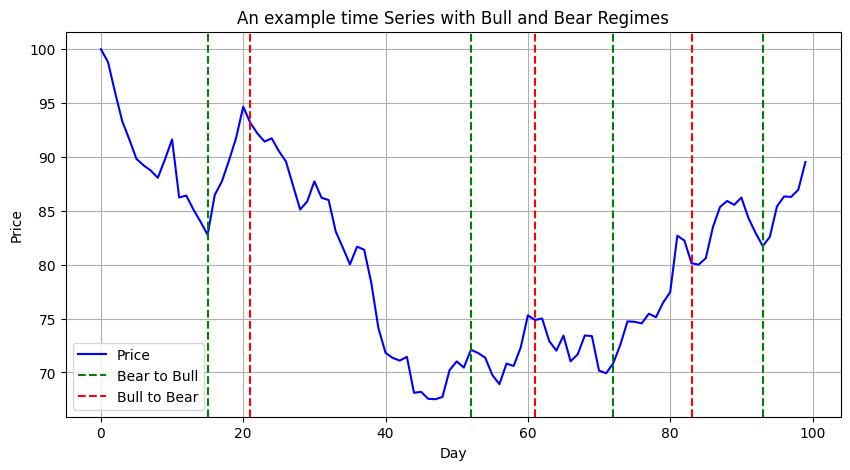

In [6]:
# Function to generate a time series with bull and bear regimes
def generate_time_series(num_days, bull_mean_return, bear_mean_return, std_dev):
    # Generate random days for regime switches
    num_switches = np.random.randint(1, 10)
    switch_days = sorted(np.random.randint(1, num_days, size=num_switches))

    # Initialize price array and regime array
    prices = np.zeros(num_days)
    regimes = np.empty(num_days, dtype=object)

    # Iterate over each day to simulate price movements based on regime
    for i in range(num_days):
        if i == 0:
            prices[i] = 100
        else:
            # Determine regime based on switch days
            if i in switch_days:
                if regimes[i-1] == 'Bull':
                    regime = 'Bear'
                else:
                    regime = 'Bull'
            else:
                regime = regimes[i-1]

            # Simulate daily return and update price
            if regime == 'Bull':
                mean_return = bull_mean_return
            else:
                mean_return = bear_mean_return

            daily_return = np.random.normal(mean_return, std_dev)
            prices[i] = prices[i-1] * (1 + daily_return)
            regimes[i] = regime

    return prices, regimes, switch_days

# Generate time series data
np.random.seed(42)
num_days = 100
bull_mean_return = 0.015
bear_mean_return = -0.01
std_dev = 0.02
prices, regimes, switch_days = generate_time_series(num_days, bull_mean_return, bear_mean_return, std_dev)

# Plot the time series with regime switches
plt.figure(figsize=(10, 5))
plt.plot(prices, label='Price', color='blue')

# Initialize variables for legend labels
bull_to_bear_label = False
bear_to_bull_label = False

# Plot regime switch days
for i, switch_day in enumerate(switch_days):
    if regimes[switch_day - 1] == 'Bull':
        plt.axvline(x=switch_day, linestyle='--', color='red', label='Bull to Bear' if not bull_to_bear_label else None)
        bull_to_bear_label = True
    else:
        plt.axvline(x=switch_day, linestyle='--', color='green', label='Bear to Bull' if not bear_to_bull_label else None)
        bear_to_bull_label = True

plt.title('An example time Series with Bull and Bear Regimes')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Hidden Markov Model (HMM)

The Hidden Markov Models is used to model sequential data that satisfy the first-order Markov property <cite data-cite='li_2023'></cite>, which means the future states depend only on the current state. In HMM, the realization at $t$ is influenced by regime (hidden state), which is unobserved. The transition probability matrix of HMM is constant. The observation at time $t$ is associated with a probability distribution corresponding with the hidden state. The two types of HMMs are

- Discrete HMM
- Continuous HMM

In this study, we consider discrete HMM with the regimes corresponding to 'Bull', 'Bear' and 'Stagnant'.

The discrete HMMs has 3 parameters

-  $\pi$ - Initial probability vector
-  $A$ - State transition probability matrix
-  $B$ - Emission probability matrix

**Constraints**

- Total transition probability from initial state to all hidden states is 1
- From a hidden state to all other hiddens states is 1
- From hidden state to all observed state is 1

**Three main problems and solutions**

1. Evaluation: Given observation and model parameters, calculating the probability of observation

3. Decoding: Given observation and model parameters, finding the most likely sequence in the hidden state

5. Training: Given observation, identifying the HMM parameters

The evaluation problem is solved by Forward and Backward algorithm, the decoding problem by Viterbi algorithm and the training by Baum-Welch algorithm.

# Macro research

Macro strategies assist portfolio managers in making better investment decisions <cite data-cite='alvi_2018'></cite>. In oil trading, global macro strategy is used for analyzing large-scale events like geopolitics, monetary policy, and supply-demand factors to assist energy traders in making better investment and trading decisions.

Oil trading is sensitive to geopolitical events and economic indicators. Global macro strategy is used to reduce these impacts on trading with changing oil prices.

Let us understand how crude oil is a vital key player in global macro strategy to observe the macroeconomic behavior. The macroeconomic stability of crude oil has a long-term impact on influencing the economic growth of countries.

Macroeconomic indicators are used to devise this strategy. To predict the movements in oil prices we need to assess the economic environment, which is assisted by developing an understanding in macroeconomic variables.

Macroeconomic indicators are in the form of economic time-series collected by federal statistical bodies Eg. Energy Information Administration (EIA) for data for the energy markets and Federal Reserve Economic Data (FRED) for macroeconomic data. Such macroeconomic data is used to forecast oil prices which is the aim of macro research.

The Methodology used in the macro research is to use probabilistic graphical models like Belief Networks and Hidden Markov Models for oil market analysis.

## Data sources

Now we will see in detail two popular data Sources that macro research relies on.

### Energy Information Administration (EIA)

In macroeconomic research, one of the common data source which used to collect, analyze, and spread out energy-related information is from Energy Information Administration (EIA). Researchers use EIA data to understand the dynamics of energy markets. These dynamics are supply, demand, and pricing trends etc. EIA datasets are used in macroeconomic models by analysts which assists them in assessing the impact of energy factors on the economy, making informed decisions, and predicting future trends in energy markets.

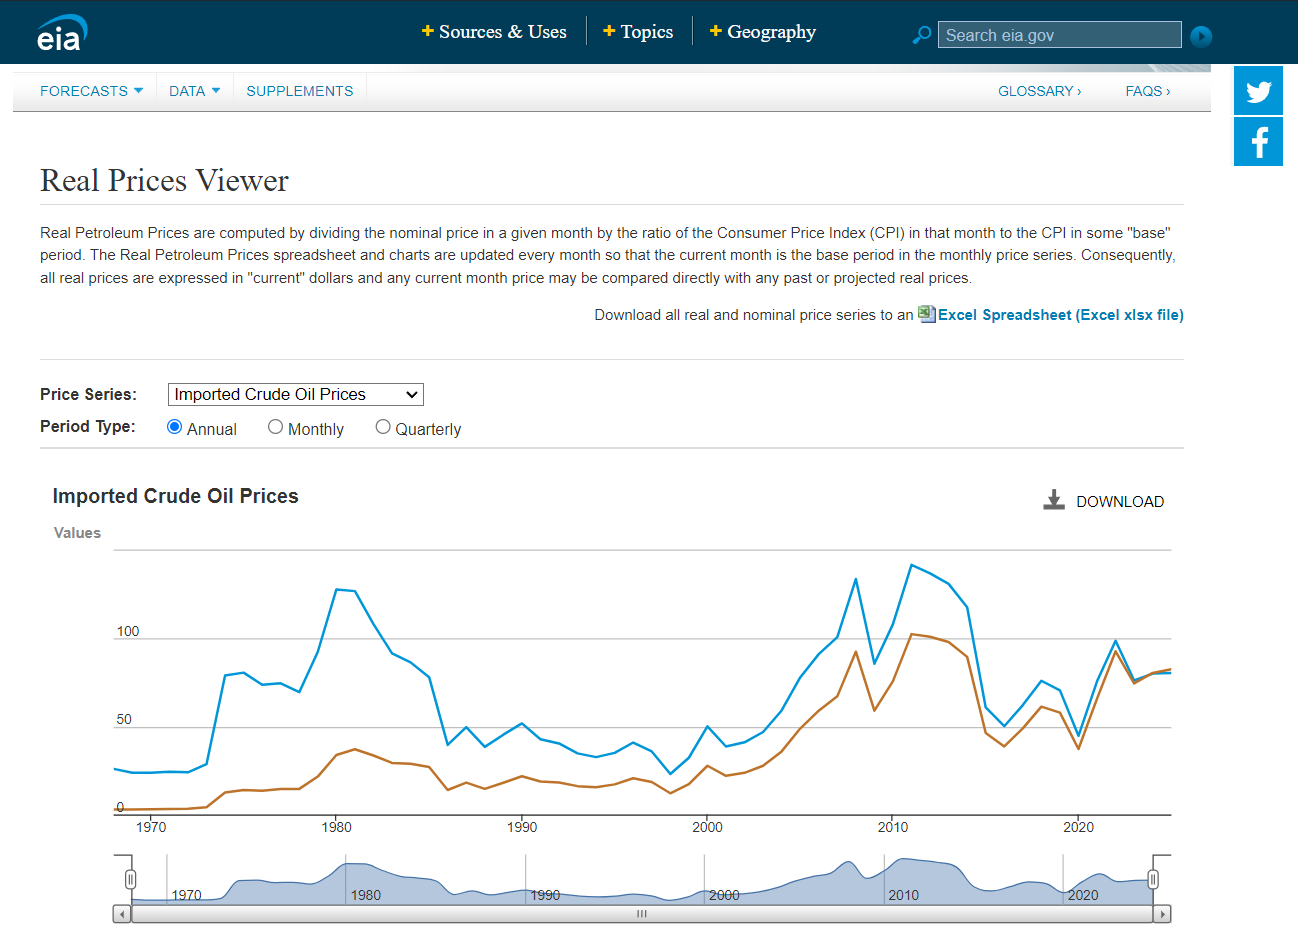

### Federal Economic Reserve Data

FRED is one of the primary data sources for macroeconomic data. The macroeconomic variables which play a vital role in oil pricing and in oil markets are influenced by the monetary policy of the Federal Reserve Bank.

Eg: Industrial growth, Industrial production, capacity, and capacity utilization. 

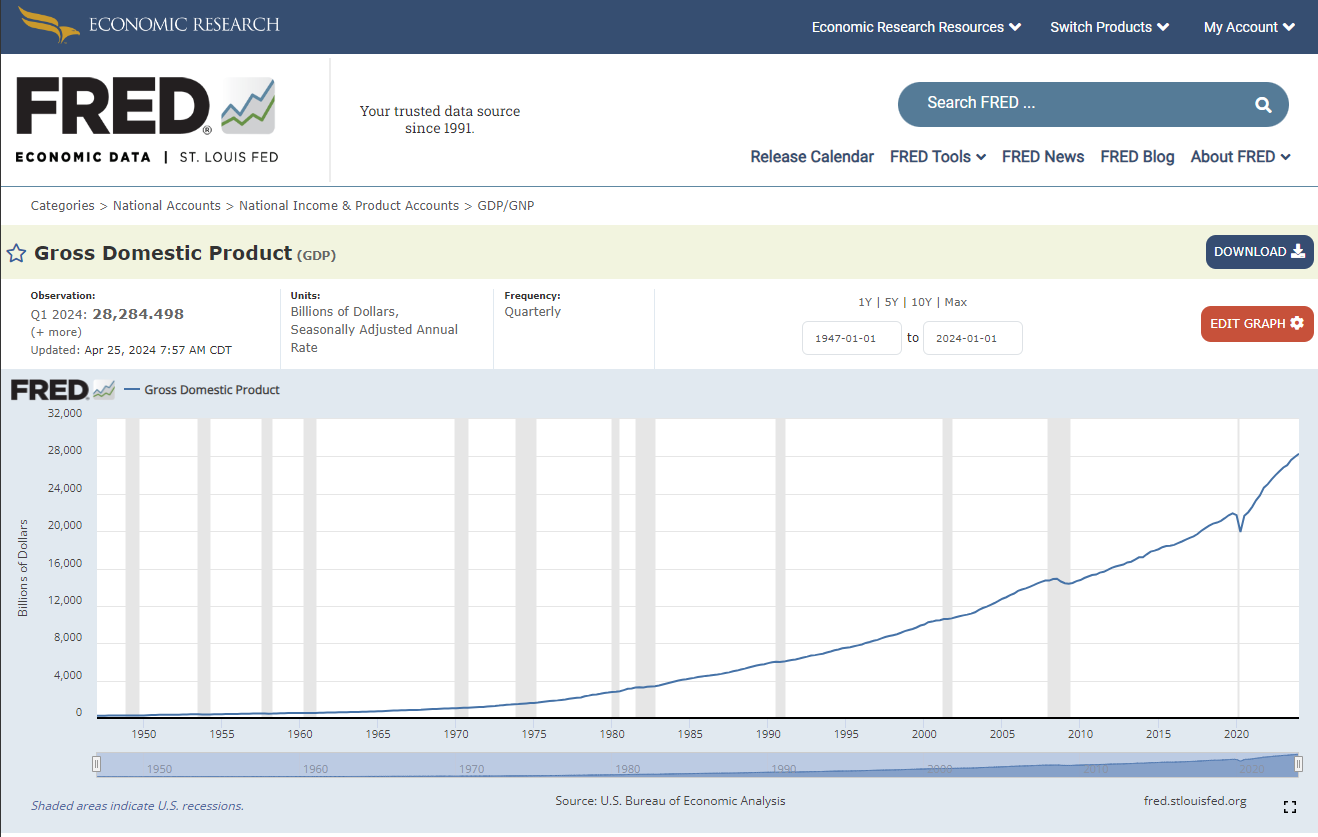


## Macro indicators

Macroeconomic indicators affect crude oil markets. We can get insights about the performance of a state’s economy. These indicators help us understand how the macro variables are causally related. They help energy traders predict future trends and make informed decisions.

Along with other physical factors these indicators are also used in macro research to study the economic trends, forecast economic conditions, and develop economic policies in future. Researchers analyze these data sources to gain valuable insights into how the economy is functioning and promote economic stability.

### Macro indicators identification

They have a significant impact on energy markets. They are identified from Federal statistical bodies who have reliable data sources. Researchers collect relevant datasets from sources like the Energy Information Administration (EIA) and the Federal Reserve Economic Data (FRED) to incorporate into models. By understanding these indicators researchers assist energy traders and portfolio managers to gain insights into the trends and influences affecting the energy markets, enabling better decision-making and forecasting.

Example Macro indicators: production, consumption, policy, GDP growth, and geopolitical factors

### Common macroeconomic indicators

- GDP (Gross Domestic Product) is a key indicators which measures the total value of all goods and services produced within a country's borders. 
- Unemployment Rate helps us understand the employment rate in the labour market. It measures the percentage of which labor force that is unemployed and seeking employment. 
- The inflation Rate indicates the cost of living Inflation and the purchasing power of an economy.  The rate at which prices for goods and services are rising. 
- Interest Rates of Central banks influence borrowing, and investment decisions have a major impact on economic growth and inflation.
- Consumer Confidence Index is measure of sentiment of consumers regarding the state of the economy. High consumer confidence leads to increased spending, while low confidence indicates economic uncertainty.
- The trade balance measures the difference between a country's exports and imports. surplus indicates the country is exporting more which can be beneficial.
  
### Dataset retrieval

As discussed above, the dataset are derived from  Energy Information Administration (EIA) and the Federal Reserve Economic Data (FRED) data source. 

In several ways these data can be extracted to be used in building macro strategy, one of them is using Python APIs. 

Once the datasets are extracted we pandas data frame to proceed with data preprocessing stages. Researchers can access wide range of macroeconomic indicators that are relevant to the markets they are looking to analyse and derive insights.

Example: production, consumption, and pricing data. 

Using API, we can ensure we have up-to-date data which can help in analysing and building the strategy models. 

## Data cleaning process

Data cleaning or Data preprocessing is the process where inconsistencies in the data are removed. 

Data Inconsistencies include noise in the data, missing values, out-of-range values, and unformatted data.
what can happen if the data is not preprocessed/cleaned, analysis will get inaccurate results which could be misleading.

### Data cleaning Steps

- Removing unwanted data - Duplicate/redundant or Irrelevant values detection. 
- Missing Data Handling - Fixing issues of unknown missing values.
- Structural error solving - Fixing problems with mislabeled classes, typos in names of features, same attribute with different names etc.
- Outlier Management - Unwanted values which are not fit in datasets.
  
## Dataset preparation

Machine learning algorithms rely on datasets to learn and build the model.

Macro strategy research uses Bayesian model and belief network. K-fold cross-validation method is adopted (leave-one-out cross-validation with k=3) to validate and tune training models.

A common ratio of 80:10:10 is employed for splitting the data into training, validation, and testing sets, ensuring statistical confidence. Each validation and testing dataset spans 33 months, in line with the "30x rule of thumb."

### Training dataset

It is used to train the model. From the preprocessed dataframe, we’ll use a portion of it that contains a set of input data features and output labels. The model learns patterns from this training data and adjusts its parameter values in the activation function to minimize the error, which is the difference between actual and predicted output. Training data makes the model more generalized so that it can predict well for unseen data. Here in macro research, the training set is used to learn parameters in the belief network using Hill Climbing algorithm.

### Testing dataset

The performance of the trained model is assessed using a test set, which is a portion of the preprocessed dataset. We do not use test set to develop the model, it's purely used for evaluation purpose. It basically represents the unseen data in real-world, which helps researched estimate how well the model generalizes. In macro strategy, researchers use this dataset to evaluate the fully-trained model to estimate the error rate.


### Validation dataset

From the training set, we divide certain portions to test and finetune the developed model. Fine-tuning involves setting the hyperparameters of the model in such a way that it generalizes well and predicts accurate results.  We use learning rate and regularization methods to make the model unbiased.
Researchers iteratively adjust hyperparameters to improve the model's performance and prevent overfitting to select the best-performing model among different configurations.
In macro strategy, researchers use validation sets to assist in tuning the parameters of the belief network, experimenting with various Bayesian Dirichlet scoring functions such as BDeu or K2, and Bayesian Information Criterion (BIC).


## Python libraries

### Pandas

Pandas is used to preprocess the data and derive uniform training, validation, and testing datasets. <cite data-cite='pandas'></cite>

Pandas is a versatile Python library used for intuitive data analysis. It has the required functions to create data frame and extract the required insights.

The data that we extract from EIA or FRED or both may contain many discrepancies, like noise, missing data, incorrect values etc. which will be addressed using Pandas.

### hmms

The hmms module in python provides convenient implementation of the Hidden Markov Models for regime detection using Viterbi and Baum-Welch Algorithm <cite data-cite='alvi_2018'></cite>.

To model the regime switches, the time-series is first converted into zeros and ones based on the monthly return.

- The timestep takes a value of 1 if the return is positive
- Takes a value of 0 if the return is negative

      e_seq = np.array(price_diff.apply(lambda x: 1 if x > 0 else 0).values, dtype=np.int32)
        

An instance `dhmm` of discrete HMM `hmms.DtHMM` is created with three hidden states ('Bull', 'Bear' and 'Stagnant') and the above two realization. The initial parameters are set as random and in the next step, the model will learn the parameters from the data.

      dhmm = hmms.DtHMM.random(3, 2)

The observed emissions (0s and 1s) are passed to the Baum-Welch algorithm `dhmm.baum_welch` to learn the parameters ($\pi$, $A$, $B$).

      dhmm.baum_welch(e_seq)

The emissions and the learnt paramaters are then used to find the most likely hidden state at each time-step using the Viterbi algorithm `dhmm.viterbi`.

      (log_prob, s_seq) = dhmm.viterbi(e_seq)

Where s_seq is the most likely hidden state (regimes) that emits the given observations.

Thus, by using HMM, we can be able to discretize the time series into various regimes, which can then be used to construct the belief network.

### pgmpy

Once we discretize the series in the dataset, we can use pgmpy package to construct and learn the belief network. The pgmpy package provides the implementation of Hill Climb algorithm along with the popular Bayesian scoring methods. <cite data-cite='pgmpy'></cite> Hill climb search is a partially exhaustive algorithm that maximises the network score. Thus, the convergence of the algorithm to the global maxima depends on the initial state. If we have expert knowledge about the data, we can set the initial state of the network according to it. By setting the expert knowledge as an initial seed, the convergence to global maxima by the model is most likely. 

The python implementation is straightforward.

We first create an instance of hill climb search and estimate the structure of the Bayesian network.

    hc = HillClimbSearch(df)
    est = hc.estimate(max_iter=100)

Once the structure is estimated, a Bayesian Network object is initialized using the structure obtained from the hill climb search.

    model = BayesianNetwork(est)

We then fit the network to the data. This is where the model training happens.

    model.fit(df, estimator=BayesianEstimator, prior_type='K2')

Once the training is complete, we can use `model.predict` method to make inferences from the trained network.

# HMM impletmentation

## Time-series transformation

The first step is to transform the time-series into zeros and ones if the months return is negative or positive. This series is the observation parameter that the HMM model takes. To do this, we first calculate the difference from the previous month, then apply the mentioned transformation.

In [7]:
df = pd.read_csv('WTISPLC.csv', index_col='DATE')
df.index = pd.to_datetime(df.index)
print('Original Time series:')
print(df.shape)
print(df.head())

Original Time series:
(171, 1)
            WTISPLC
DATE               
2010-01-01    78.22
2010-02-01    76.42
2010-03-01    81.24
2010-04-01    84.48
2010-05-01    73.84


In [8]:
df['Observation'] = (df.diff() > 1).astype(int)
print('Transformed Time series:')
print(df.shape)
print(df.head())

Transformed Time series:
(171, 2)
            WTISPLC  Observation
DATE                            
2010-01-01    78.22            0
2010-02-01    76.42            0
2010-03-01    81.24            1
2010-04-01    84.48            1
2010-05-01    73.84            0


## Parameter learning

Once the transformation is done, the parameters $\pi, A, B$ are learnt by using Baum-Welch Algorithm. As the Baum-Welch implementation takes a list of arrays with size less than or equal to 32, we need to split the observations.

In [9]:
emissions = np.array_split(df['Observation'].values, 32)
print('Emissions split into 32 arrays:')
print(emissions)

Emissions split into 32 arrays:
[array([0, 0, 1, 1, 0, 1]), array([1, 0, 0, 1, 1, 1]), array([0, 0, 1, 1, 0, 0]), array([0, 0, 0, 0, 1, 1]), array([1, 1, 1, 0, 0, 0]), array([1, 1, 0, 0, 0, 1]), array([1, 0, 0, 0, 1, 0]), array([1, 1, 0, 0, 0, 1]), array([0, 1, 0, 1, 0, 1]), array([0, 0, 0, 0, 0, 0]), array([0, 1, 0, 1, 1, 0]), array([0, 0, 1, 0, 0]), array([0, 0, 0, 1, 1]), array([1, 1, 0, 0, 0]), array([1, 0, 1, 0, 0]), array([0, 1, 0, 0, 1]), array([1, 1, 1, 1, 1]), array([1, 0, 0, 1, 1]), array([0, 1, 0, 1, 0]), array([0, 0, 1, 1, 1]), array([1, 0, 0, 1, 0]), array([1, 0, 1, 1, 0]), array([0, 0, 0, 1, 1]), array([1, 1, 0, 0, 1]), array([1, 1, 1, 1, 0]), array([1, 1, 1, 0, 1]), array([1, 0, 0, 1, 1]), array([1, 0, 1, 1, 0]), array([0, 0, 1, 0, 0]), array([1, 0, 0, 1, 0]), array([0, 1, 1, 1, 0]), array([0, 0, 1, 1, 1])]


After splitting the the observations, we instantiate a discrete hmm with random parameters with 3 states and 2 observations.

In [10]:
dhmm = hmms.DtHMM.random(3, 2)
hmms.print_parameters(dhmm)

Initial probabilities (π) :


,0
0,0.114715
1,0.448865
2,0.436421


Transition probabilities matrix (A):


,0,1,2
0,0.295686,0.703749,0.000565
1,0.428913,0.370777,0.200310
2,0.312086,0.283302,0.404613


Emission probabilities matrix (B):


,0,1
0,0.524620,0.475380
1,0.434798,0.565202
2,0.580185,0.419815


Then, the observations are passed to the Baum Welch algorithm to learn the parameters.

In [11]:
dhmm.baum_welch(emissions, iterations=100)

iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

In [12]:
hmms.print_parameters(dhmm)

Initial probabilities (π) :


,0
0,0.048644
1,0.434947
2,0.516410


Transition probabilities matrix (A):


,0,1,2
0,0.230355,0.769635,0.000010
1,0.024543,0.494746,0.480711
2,0.706238,0.011246,0.282516


Emission probabilities matrix (B):


,0,1
0,0.917887,0.082113
1,0.105566,0.894434
2,0.706458,0.293542


## Regime learning

After learning the model parameters, we can learn the regimes (Bull, Bear, Stagnant) using the Viterbi algorithm. Here, we concatenate the emissions into a 1D array.

In [13]:
np.int = int
log_prob, s_seq = dhmm.viterbi(np.concatenate(emissions, dtype=np.int))
print('Likely sequence:\n', s_seq)
print('Log probability', log_prob)

Likely sequence:
 [2 0 1 2 0 1 1 2 0 1 1 1 2 0 1 1 2 0 1 2 0 0 1 1 1 1 1 2 0 0 1 1 2 0 0 1 1
 2 0 1 2 0 1 1 2 0 1 2 0 1 2 2 0 1 2 0 1 2 0 0 1 2 0 1 1 2 0 0 1 2 0 1 2 0
 1 1 1 1 2 0 1 2 0 1 2 0 0 1 2 0 1 1 1 1 1 1 1 2 0 1 1 2 2 0 1 2 0 0 1 1 1
 1 2 0 1 2 2 0 1 1 2 0 0 0 1 1 1 1 2 0 1 1 1 1 2 0 1 1 2 0 1 1 2 0 1 1 2 0
 1 1 2 0 0 1 2 0 1 2 0 1 2 0 1 1 1 2 0 0 1 1 1]
Log probability -152.67234893005116


We can plot the regimes on the price plot to visualize.

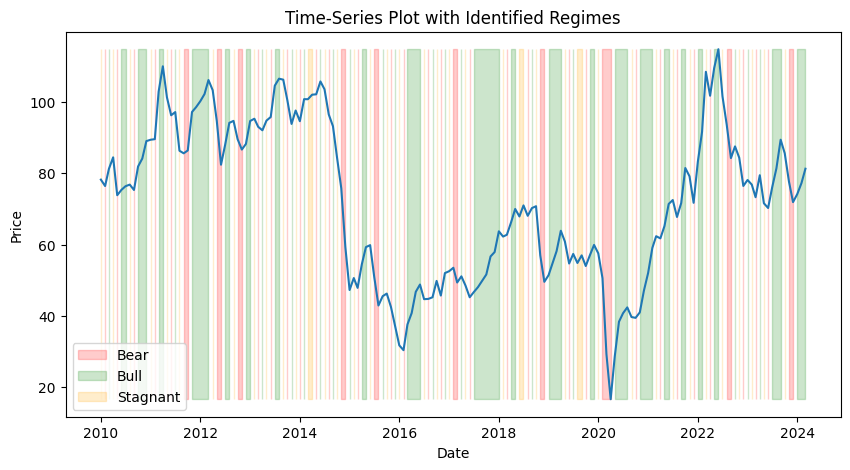

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(df['WTISPLC'])
regime_labels = ['Bear', 'Bull', 'Stagnant']
regime_colors = ['red', 'green', 'orange']
for i, regime in enumerate(np.unique(s_seq)):
    plt.fill_between(df.index, df['WTISPLC'].min(), df['WTISPLC'].max(),
                     where=(s_seq == regime),
                     color=regime_colors[i], alpha=0.2, label=regime_labels[regime])
plt.title('Time-Series Plot with Identified Regimes')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Identification of latent meaning behind each hidden state

In the above trained Hidden Markov Models (HMMs) we detect the regime using viterbi algorithm. This regime detection process represent the hidden states  the latent market regimes of the financial market.

Each hidden state bullish, bearish, or stagnant regimes captures a different underlying market condition, which drive the observed changes in the price of the asset.

From the above visualization we can observe there are transitions between these hidden states, which are derived from HMM probabilities that captures the dynamics of market regime changes over time.

The transitions between these hidden states, governed by transition probabilities in the HMM, capture the dynamics of market regime changes over time.

By identifying the latent meaning behind each hidden state, researchers can gain insights into the underlying market conditions driving the observed price movements and make informed decisions based on the detected regimes.

From the oil price HMM model, three hidden states/regimes (bull, bear, stagnant) detected. Let see each of them in detail which data point depicts what market regime.

- **Bull State or Bullish market regime:**
    - Represents rise in price in the market and positive investor confidence
    - Bull market shows healthy economy where businesses are expanding
    - Investors buy stocks during a bull market which are most likely to go up.
    - Example: In this state bullish regime, for the day 2010-06-01, the price of WTISPLC increased by 1.51 units.

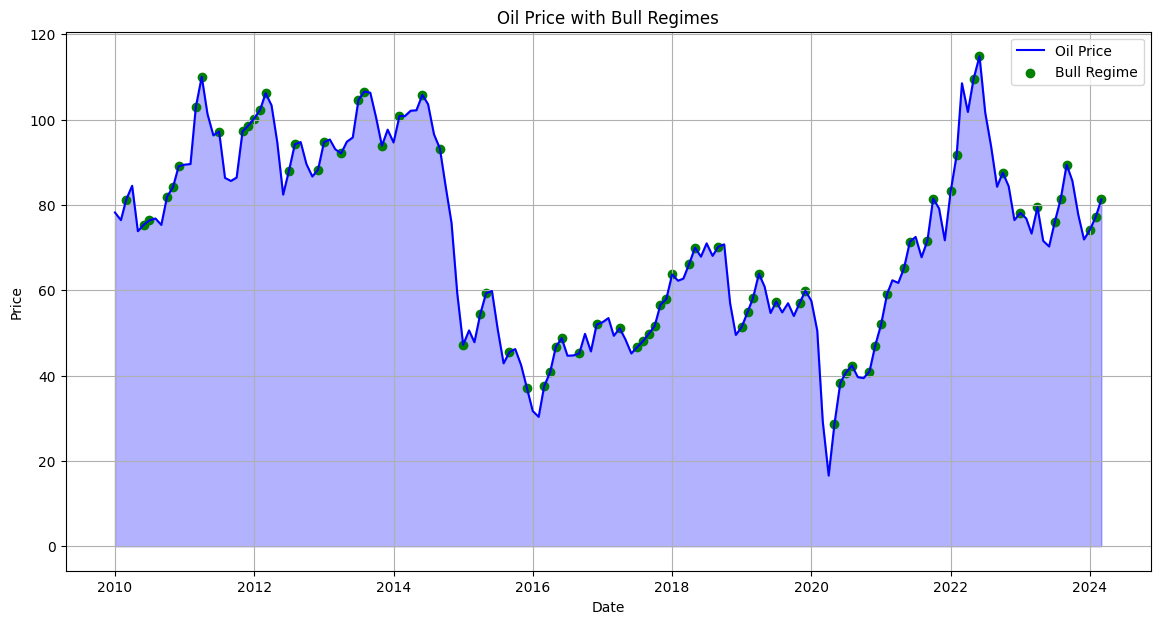

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(df['WTISPLC'], label='Oil Price', color='blue')
plt.fill_between(df.index, df['WTISPLC'], color='blue', alpha=0.3)

# Plot bull regimes
plt.scatter(df.index[s_seq == 1], df['WTISPLC'][s_seq == 1], color='green', label='Bull Regime')

plt.title('Oil Price with Bull Regimes')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

- **Bear State / Bearish market regime:**
    -  Represents fall in oil prices and negative investor sentiment.
    -  This state indicates economy is in recession
    - There will be decrease in consumer spending and business investment which affects business profits and stock prices.
    - Interest rates rises which leads to less investments from investors which eventually lowers the stock price.
    - Example: In this state bearish regime, on 2010-05-01, the price of WTISPLC dropped significantly by 10.64 units, indicates a bearish trend.

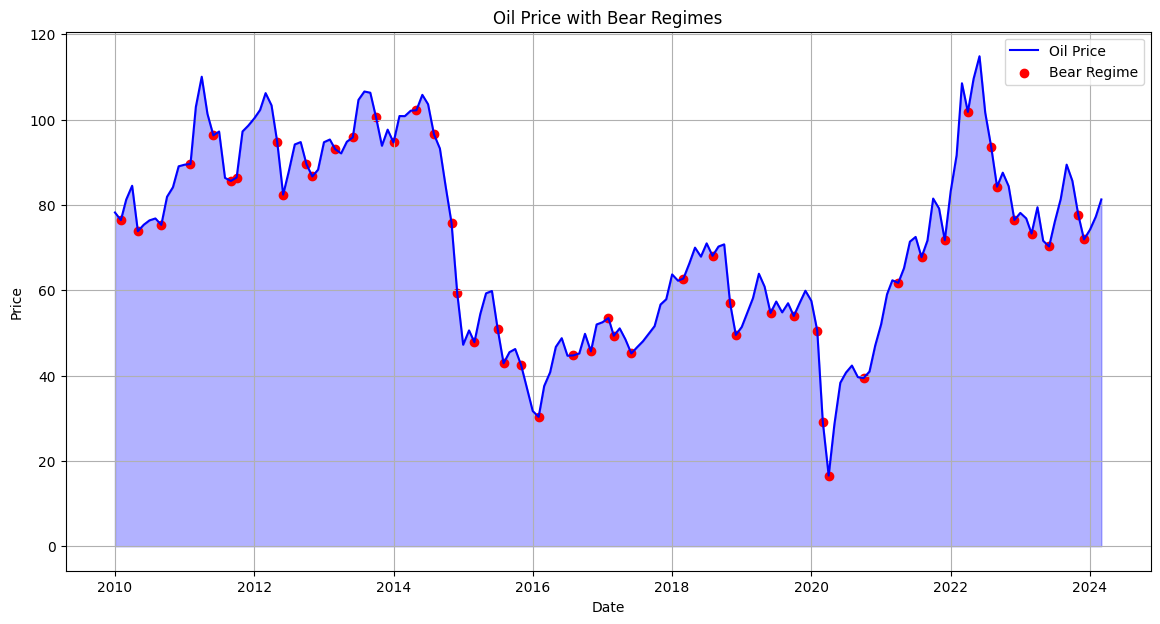

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(df['WTISPLC'], label='Oil Price', color='blue')
plt.fill_between(df.index, df['WTISPLC'], color='blue', alpha=0.3)

# Plot bull regimes
plt.scatter(df.index[s_seq == 0], df['WTISPLC'][s_seq == 0], color='red', label='Bear Regime')

plt.title('Oil Price with Bear Regimes')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

- **Stagnant State:**
    - Represents a neutral market regime with little to no change in oil prices.
    - This state indicates prices of supply and demand are equal balanced, their is no prices rise or fall.
    - This state leaves the investors with uncertainty. which makes the investors hesitant to trade buy/sell their stock which eventually leads to stagnation.
    - Example: In this state stagnant market regime, the market is relatively stable with little or no significant change in oil prices. For instance, on 2010-02-01, the price changed by -1.80 units, indicates a relatively small fluctuation.

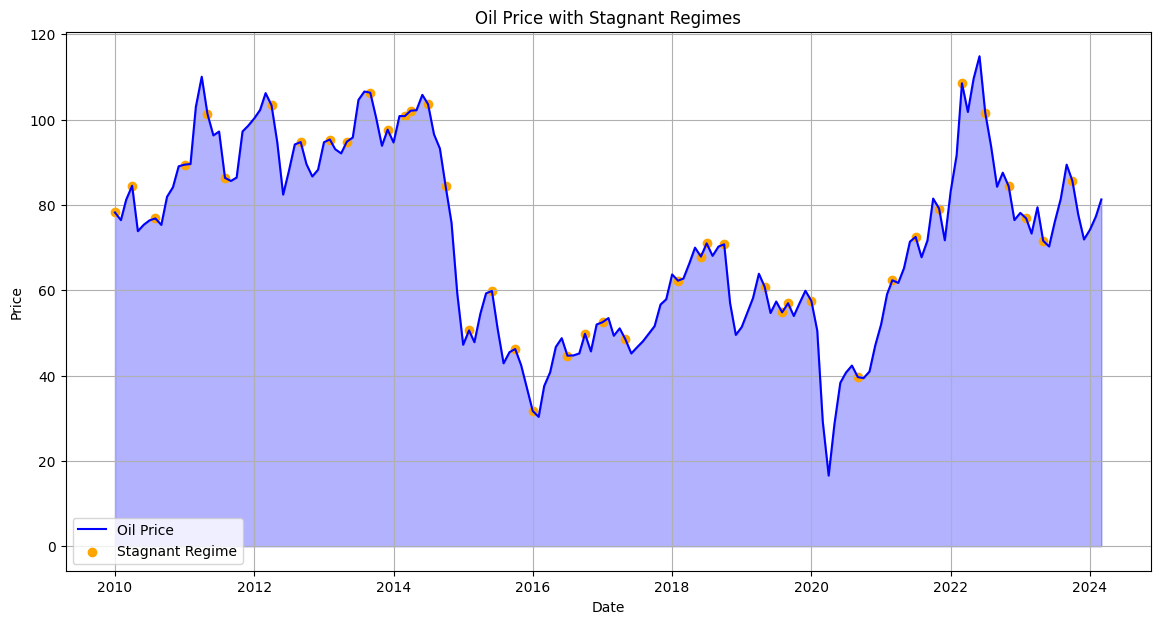

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(df['WTISPLC'], label='Oil Price', color='blue')
plt.fill_between(df.index, df['WTISPLC'], color='blue', alpha=0.3)

# Plot bull regimes
plt.scatter(df.index[s_seq == 2], df['WTISPLC'][s_seq == 2], color='orange', label='Stagnant Regime')

plt.title('Oil Price with Stagnant Regimes')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Hill Climb Search

Hill climb search is an algorithm used to learn the structure of a Probabilistic Graphical model, which is a Directed Acyclic Graph. It is a gready, iterative algorithm that maximizes the given score. <cite data-cite='hillclimb'></cite>

## Algorithm

- The hill-climb algorithm starts with a initial graph. The initial graph can be empty, full or random. 

- At each iterations, the following operations are performed by random selection of nodes:
  
    - Adding edge between nodes $u \space v$ to $u \rightarrow v$
    - Removing edge between nodes $u \rightarrow v$ to $u \space v$
    - Reversing edge between nodes $u \rightarrow v$ to $u \leftarrow v$
 
- The scoring method (K2, BIC, etc) are used to evaluate the graph.

- The operation is reversed if the score decreases.

- The algorithm stops when there is no difference between the scores.

If expert knowledge about the domain is available, we can use it as the initial graph, so that the convergence does not lead to a sub-optimal solution.

## Example

In the following example, we illustrate the working of Hill Climb search using a toy example.

- We generate a synthetic dataset, that has the following features:

    - Study time
    - Attendance
    - Sleep
    - Exam score
      
- The correlation matrix is used to define the dependencies between the variables.

- The Bayesian Network is initialized by giving expert knowledge as inputs. The expert knowledge are
      1. Study time $\rightarrow$ Exam score
      2. Attendance $\rightarrow$ Exam score
  
- The network `Bayesian Network before learning` is plotted.

- The hill climb algorithm is used to learn the structure using the expert knowledge as the initial structure.

- The network `Bayesian Network after learning` is plotted.

The plots illustrate how the Hill Climb search learns the Bayesian network. 

In [18]:
num_samples = 1000
mean_study_time = 5
mean_attendance = 90
mean_sleep = 7
mean_exam_score = 80

# Define the correlation matrix
corr_matrix = np.array([
    [1.0, 0.8, 0.3, 0.9],  # Study Time
    [0.8, 1.0, 0.4, 0.7],  # Attendance
    [0.3, 0.4, 1.0, 0.2],  # Sleep
    [0.9, 0.7, 0.2, 1.0]   # Exam Score
])

# Generate correlated data using multivariate normal distribution
data = np.random.multivariate_normal(
    [mean_study_time, mean_attendance, mean_sleep, mean_exam_score],
    corr_matrix,
    size=num_samples
)

sample = pd.DataFrame(data, columns=['study_time', 'attendance', 'sleep', 'exam_score'])

In [19]:
hc = HillClimbSearch(sample)
est = hc.estimate(max_iter=0)
model_before = BayesianNetwork(est)
model_before.add_edges_from([
    ('study_time', 'exam_score'),
    ('attendance', 'exam_score')
])

0it [00:00, ?it/s]

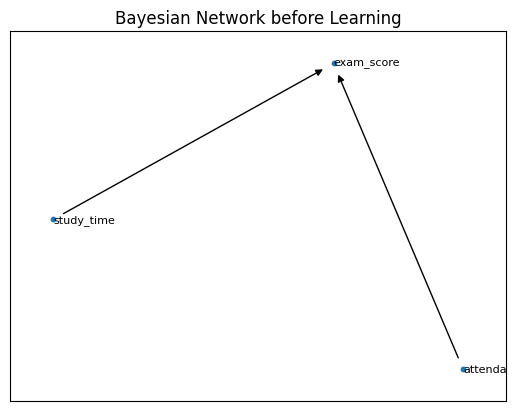

In [20]:
G_before = nx.DiGraph()
G_before.add_edges_from(model_before.edges())
pos_before = nx.spring_layout(G_before)
nx.draw_networkx_nodes(G_before, pos_before, node_size=10)
nx.draw_networkx_edges(G_before, pos_before, arrows=True)
nx.draw_networkx_labels(G_before, pos_before, font_size=8, horizontalalignment='left')
plt.title('Bayesian Network before Learning')
plt.show()

In [21]:
hc = HillClimbSearch(sample)
est = hc.estimate(max_iter=100, start_dag=model_before)
model_after = BayesianNetwork(est)

  0%|          | 0/100 [00:00<?, ?it/s]

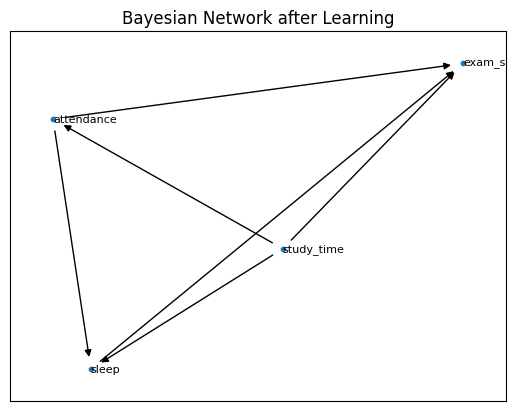

In [22]:
G_after = nx.DiGraph()
G_after.add_edges_from(model_after.edges())
pos_after = nx.spring_layout(G_after)
nx.draw_networkx_nodes(G_after, pos_after, node_size=10)
nx.draw_networkx_edges(G_after, pos_after, arrows=True)
nx.draw_networkx_labels(G_after, pos_after, font_size=8, horizontalalignment='left')
plt.title('Bayesian Network after Learning')
plt.show()